<a href="https://colab.research.google.com/github/Tuan-LeHoang/hira_kata_recognition/blob/main/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/2023_Project/OCR

/content/drive/MyDrive/2023_Project/OCR


In [2]:
!ls

data			  hira_better_quality	   models
Data_Exploring.ipynb	  hira_better_quality.zip  Report
git_lfs_handwritten_hira  __MACOSX		   Train.ipynb


In [3]:
# !pip install japanize_matplotlib
# !pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 77.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=4cf6dad069a7e3367b5b4ce86d0f131bee80c116f0d64cefd08f563ca3ea0f8a
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.1 MB/s eta 0:00:00


In [11]:
# !pip install tensorboard

#0. Import libs

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np # data processing
import matplotlib.pyplot as plt # Data visualization
import japanize_matplotlib
from tqdm import tqdm # Progress bar


In [5]:
import os
import pandas as pd
import torch.nn.functional as F

#1. EDA

#2. Load data

##2.1. From raw data

In [6]:
list_characters_folders = "./git_lfs_handwritten_hira/hira_better_quality"

In [7]:
data = []
for folder in os.listdir(list_characters_folders):
    if folder == ".DS_Store":
        continue
    character_folder = os.path.join(list_characters_folders, folder)

    for character_image in os.listdir(character_folder):
        if character_image == ".DS_Store":
            continue
        character_image_path = os.path.join(character_folder, character_image)
        data.append([character_image_path, folder])

df = pd.DataFrame(data, columns=['file_name','label'])

In [8]:
df

,file_name,label
0,./git_lfs_handwritten_hira/hira_better_quality...,あ
1,./git_lfs_handwritten_hira/hira_better_quality...,あ
2,./git_lfs_handwritten_hira/hira_better_quality...,あ
3,./git_lfs_handwritten_hira/hira_better_quality...,あ
4,./git_lfs_handwritten_hira/hira_better_quality...,あ
...,...,...
2475,./git_lfs_handwritten_hira/hira_better_quality...,ん
2476,./git_lfs_handwritten_hira/hira_better_quality...,ん
2477,./git_lfs_handwritten_hira/hira_better_quality...,ん
2478,./git_lfs_handwritten_hira/hira_better_quality...,ん


In [9]:
sort_df = df.sort_values(by=["label"])

In [10]:
sort_df

,file_name,label
0,./git_lfs_handwritten_hira/hira_better_quality...,あ
29,./git_lfs_handwritten_hira/hira_better_quality...,あ
30,./git_lfs_handwritten_hira/hira_better_quality...,あ
31,./git_lfs_handwritten_hira/hira_better_quality...,あ
32,./git_lfs_handwritten_hira/hira_better_quality...,あ
...,...,...
2447,./git_lfs_handwritten_hira/hira_better_quality...,ん
2448,./git_lfs_handwritten_hira/hira_better_quality...,ん
2449,./git_lfs_handwritten_hira/hira_better_quality...,ん
2451,./git_lfs_handwritten_hira/hira_better_quality...,ん


In [11]:
labels = sort_df["label"].unique()
print(labels)

['あ' 'い' 'う' 'え' 'お' 'か' 'き' 'く' 'け' 'こ' 'さ' 'し' 'す' 'せ' 'そ' 'た' 'ち' 'つ'
 'て' 'と' 'な' 'に' 'ぬ' 'ね' 'の' 'は' 'ひ' 'ふ' 'へ' 'ほ' 'ま' 'み' 'む' 'め' 'も' 'や'
 'ゆ' 'よ' 'ら' 'り' 'る' 'れ' 'ろ' 'わ' 'を' 'ん']


Convert labels to one-hot vectors labels

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [13]:
# Convert labels to numeric representation
def convert_to_one_hot_vector_labels(labels):
  label_encoder = LabelEncoder()
  numeric_labels = label_encoder.fit_transform(labels)
  # print("Numeric labels:", numeric_labels)

  # Convert numeric labels to one-hot vectors
  onehot_encoder = OneHotEncoder(sparse=False)
  onehot_labels = onehot_encoder.fit_transform(numeric_labels.reshape(-1, 1))

  return onehot_labels

##2.2. Split data

In [14]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(sort_df,
                                      test_size = 0.2,
                                      random_state = 42)

In [15]:
len(train_df)

1984

In [17]:
len(test_df)

496

##2.3. Dataset and Dataloader

In [18]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

In [19]:
cfg.root_dir = list_characters_folders
cfg.image_size = 224
cfg.batch_size = 32
cfg.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
class CustomDataset(Dataset):
    def __init__(self,
                 cfg,
                 df,
                 transform=None,
                  mode = None):
        self.root_dir = cfg.root_dir
        self.df = df
        self.file_names = df['file_name'].values
        self.labels = convert_to_one_hot_vector_labels(df['label'].values)

        if transform and mode != "val":
          self.transform = transform
        elif mode == "train":
          self.transform = A.Compose([A.Resize(cfg.image_size, cfg.image_size),
                             A.Rotate(p=0.6, limit=[-20,20]),
                            #  A.HorizontalFlip(p = 0.6),
                             A.CoarseDropout(max_holes = 1, max_height = 32, max_width = 32, p = 0.3),
                             ToTensorV2()])
        elif mode == "val":
          self.transform = A.Compose([A.Resize(cfg.image_size, cfg.image_size),
                             ToTensorV2()])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get file_path and label for index
        label = self.labels[idx]
        file_path = self.file_names[idx]
        # file_path = os.path.join(self.root_dir, self.file_names[idx])

        # Read an image with OpenCV
        image = cv2.imread(file_path)

        # Convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Apply augmentations
        augmented = self.transform(image=image)
        image = augmented['image']

        # Normalize because ToTensorV2() doesn't normalize the image
        image = image/255

        return image, label

In [21]:
train_dataset = CustomDataset(cfg, train_df, mode = "train")
valid_dataset = CustomDataset(cfg, test_df, mode = "val")

train_dataloader = DataLoader(train_dataset,
                          batch_size = cfg.batch_size,
                          shuffle = True)

valid_dataloader = DataLoader(valid_dataset,
                          batch_size = cfg.batch_size,
                          shuffle = False,
                              )

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#3. Model

In [22]:
import timm

cfg.n_classes = len(labels)
cfg.backbone = 'resnet18'

model = timm.create_model(cfg.backbone,
                          pretrained = False,
                          num_classes = cfg.n_classes)

In [23]:
model = model.to(cfg.device)

In [ ]:
X = torch.randn(cfg.batch_size, 3, cfg.image_size, cfg.image_size)
y = model(X)

In [ ]:
cfg.image_size

224

In [ ]:
y.shape

torch.Size([32, 46])

#4. Loss function, Optimizer, learning rate scheduler, measure metrics

In [24]:
criterion = nn.CrossEntropyLoss()

In [25]:
cfg.learning_rate = 1e-3

optimizer = torch.optim.Adam(
  model.parameters(),
  lr = cfg.learning_rate,
  weight_decay = 0,
 )

In [26]:
cfg.lr_min = 1e-5
cfg.epochs = 50

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
  optimizer,
  T_max = np.ceil(len(train_dataloader.dataset) / cfg.batch_size) * cfg.epochs,
  eta_min = cfg.lr_min
)

In [27]:
from sklearn.metrics import accuracy_score

def calculate_metric(y, y_pred):
  metric = accuracy_score(y, y_pred)
  return metric

#5. Set up tensor board

In [28]:
from torch.utils.tensorboard import SummaryWriter

In [29]:
import datetime

In [30]:
log_dir = "logs/fit/resnet18/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [31]:
log_dir

'logs/fit/resnet18/20230712-082204'

In [32]:
writer = SummaryWriter(log_dir = log_dir)

#5. Training pipeline

In [ ]:
cfg.device

device(type='cuda', index=0)

In [33]:
def train_one_epoch(dataloader, model, optimizer, scheduler, cfg):
    # Training mode
    model.train()

    # Init lists to store y and y_pred
    final_y = []
    final_y_pred = []
    final_loss = []

    # Iterate over data
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)
        y = batch[1].to(cfg.device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # Forward: Get model outputs
            y_pred = model(X)

            # Forward: Calculate loss
            loss = criterion(y_pred, y)

            # Covert y and y_pred to lists
            final_loss.append(loss.item())

            # Backward: Optimize
            loss.backward()
            optimizer.step()

        scheduler.step()

    # Calculate statistics
    loss = np.mean(final_loss)

    return loss

In [34]:
def validate_one_epoch(dataloader, model, cfg):
    # Validation mode
    model.eval()

    final_y = []
    final_y_pred = []
    final_loss = []

    # Iterate over data
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)
        y = batch[1].to(cfg.device)

        with torch.no_grad():
            # Forward: Get model outputs
            y_pred = model(X)

            # Forward: Calculate loss
            loss = criterion(y_pred, y)

            # Covert y and y_pred to lists
            y =  y.detach().cpu().numpy().tolist()
            y_pred =  y_pred.detach().cpu().numpy().tolist()

            # Extend original list
            final_y.extend(y)
            final_y_pred.extend(y_pred)
            final_loss.append(loss.item())

    # Calculate statistics
    loss = np.mean(final_loss)
    final_y_pred = np.argmax(final_y_pred, axis=1)
    final_y_argmax = np.argmax(final_y, axis = 1)
    metric = calculate_metric(final_y_argmax, final_y_pred)

    return metric, loss

#6. Train

In [35]:
import random

def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    # In general seed PyTorch operations
    torch.manual_seed(seed)

    # If you are using CUDA on 1 GPU, seed it
    torch.cuda.manual_seed(seed)

    # If you are using CUDA on more than 1 GPU, seed them all
    torch.cuda.manual_seed_all(cfg.seed)

    # Certain operations in Cudnn are not deterministic, and this line will force them to behave!
    torch.backends.cudnn.deterministic = True

    # Disable the inbuilt cudnn auto-tuner that finds the best algorithm to use for your hardware.
    torch.backends.cudnn.benchmark = False

In [39]:
cfg.seed = 42

def train(model, optimizer, scheduler, cfg, train_dataloader, valid_dataloader = None, patience = 10, writer = None):
    loss_list = []
    val_acc_list = []
    val_loss_list = []

    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(cfg.epochs):
        print(f"Epoch {epoch + 1}/{cfg.epochs}")

        set_seed(cfg.seed + epoch)

        loss = train_one_epoch(train_dataloader, model, optimizer, scheduler, cfg)

        val_acc, val_loss = validate_one_epoch(valid_dataloader, model, cfg)
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          early_stopping_counter = 0
          print("Saving model...")
          torch.save(model.state_dict(), "best_model.pt")
        else:
          early_stopping_counter += 1

        if early_stopping_counter >= patience:
          print("Early stopping triggered.")
          break

        print(f'Loss: {loss:.4f}')
        loss_list.append(loss)

        print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        writer.add_scalar("Training loss", loss, epoch)
        writer.add_scalar("Validation loss", val_loss, epoch)
        writer.add_scalar("Valication accuracy", val_acc, epoch)
    model.load_state_dict(torch.load("best_model.pt"))
    writer.flush()
    writer.close()

    return model, loss_list, val_acc_list, val_loss_list

In [42]:
model, loss, val_acc, val_loss = train(model, optimizer, scheduler, cfg, train_dataloader, valid_dataloader, 10, writer)

Epoch 1/50


100%|██████████| 16/16 [00:01<00:00,  9.02it/s]


Saving model...
Loss: 3.7614
Val Loss: 5.1285 Val Acc: 0.0181
Epoch 2/50


100%|██████████| 16/16 [00:01<00:00, 10.07it/s]


Saving model...
Loss: 3.4906
Val Loss: 3.3874 Val Acc: 0.0746
Epoch 3/50


100%|██████████| 16/16 [00:01<00:00,  9.97it/s]


Loss: 3.1534
Val Loss: 3.8187 Val Acc: 0.0222
Epoch 4/50


100%|██████████| 16/16 [00:01<00:00, 10.10it/s]


Loss: 2.6914
Val Loss: 4.7940 Val Acc: 0.0726
Epoch 5/50


100%|██████████| 16/16 [00:01<00:00,  9.47it/s]


Loss: 2.1673
Val Loss: 4.0951 Val Acc: 0.1270
Epoch 6/50


100%|██████████| 16/16 [00:01<00:00, 10.12it/s]


Saving model...
Loss: 1.5404
Val Loss: 1.8850 Val Acc: 0.4516
Epoch 7/50


100%|██████████| 16/16 [00:01<00:00,  9.79it/s]


Saving model...
Loss: 1.0126
Val Loss: 1.4554 Val Acc: 0.5726
Epoch 8/50


100%|██████████| 16/16 [00:01<00:00,  9.59it/s]


Loss: 0.7062
Val Loss: 23.4626 Val Acc: 0.3690
Epoch 9/50


100%|██████████| 16/16 [00:01<00:00,  8.97it/s]


Loss: 0.4987
Val Loss: 3.8943 Val Acc: 0.4435
Epoch 10/50


100%|██████████| 16/16 [00:01<00:00,  9.38it/s]


Saving model...
Loss: 0.3767
Val Loss: 0.4883 Val Acc: 0.8690
Epoch 11/50


100%|██████████| 16/16 [00:01<00:00, 10.31it/s]


Loss: 0.2499
Val Loss: 5.0979 Val Acc: 0.4536
Epoch 12/50


100%|██████████| 16/16 [00:01<00:00, 10.03it/s]


Saving model...
Loss: 0.2012
Val Loss: 0.4074 Val Acc: 0.8851
Epoch 13/50


100%|██████████| 16/16 [00:01<00:00,  9.31it/s]


Loss: 0.2059
Val Loss: 2.7425 Val Acc: 0.4980
Epoch 14/50


100%|██████████| 16/16 [00:01<00:00, 10.33it/s]


Loss: 0.1687
Val Loss: 0.4723 Val Acc: 0.8649
Epoch 15/50


100%|██████████| 16/16 [00:01<00:00, 10.04it/s]


Saving model...
Loss: 0.1282
Val Loss: 0.1946 Val Acc: 0.9476
Epoch 16/50


100%|██████████| 16/16 [00:01<00:00,  9.88it/s]


Loss: 0.1176
Val Loss: 0.2192 Val Acc: 0.9435
Epoch 17/50


100%|██████████| 16/16 [00:01<00:00,  9.53it/s]


Loss: 0.0814
Val Loss: 0.5665 Val Acc: 0.8387
Epoch 18/50


100%|██████████| 16/16 [00:01<00:00,  9.77it/s]


Saving model...
Loss: 0.0924
Val Loss: 0.1916 Val Acc: 0.9617
Epoch 19/50


100%|██████████| 16/16 [00:01<00:00,  9.54it/s]


Loss: 0.0799
Val Loss: 0.3972 Val Acc: 0.8871
Epoch 20/50


100%|██████████| 16/16 [00:01<00:00,  9.84it/s]


Saving model...
Loss: 0.0676
Val Loss: 0.1095 Val Acc: 0.9738
Epoch 21/50


100%|██████████| 16/16 [00:01<00:00,  9.25it/s]


Loss: 0.0644
Val Loss: 0.7022 Val Acc: 0.8266
Epoch 22/50


100%|██████████| 16/16 [00:01<00:00, 10.18it/s]


Saving model...
Loss: 0.0534
Val Loss: 0.0872 Val Acc: 0.9839
Epoch 23/50


100%|██████████| 16/16 [00:01<00:00, 10.04it/s]


Loss: 0.0634
Val Loss: 0.1335 Val Acc: 0.9677
Epoch 24/50


100%|██████████| 16/16 [00:01<00:00,  9.43it/s]


Loss: 0.0442
Val Loss: 0.0928 Val Acc: 0.9738
Epoch 25/50


100%|██████████| 16/16 [00:01<00:00,  9.60it/s]


Loss: 0.0404
Val Loss: 0.2210 Val Acc: 0.9395
Epoch 26/50


100%|██████████| 16/16 [00:01<00:00,  9.98it/s]


Saving model...
Loss: 0.0410
Val Loss: 0.0844 Val Acc: 0.9778
Epoch 27/50


100%|██████████| 16/16 [00:01<00:00,  9.63it/s]


Saving model...
Loss: 0.0344
Val Loss: 0.0654 Val Acc: 0.9859
Epoch 28/50


100%|██████████| 16/16 [00:01<00:00,  8.79it/s]


Loss: 0.0278
Val Loss: 0.0840 Val Acc: 0.9819
Epoch 29/50


100%|██████████| 16/16 [00:01<00:00,  9.97it/s]


Saving model...
Loss: 0.0316
Val Loss: 0.0599 Val Acc: 0.9839
Epoch 30/50


100%|██████████| 16/16 [00:01<00:00,  9.83it/s]


Loss: 0.0247
Val Loss: 0.0626 Val Acc: 0.9879
Epoch 31/50


100%|██████████| 16/16 [00:01<00:00, 10.12it/s]


Loss: 0.0232
Val Loss: 0.0615 Val Acc: 0.9839
Epoch 32/50


100%|██████████| 16/16 [00:01<00:00,  9.01it/s]


Loss: 0.0207
Val Loss: 0.0689 Val Acc: 0.9819
Epoch 33/50


100%|██████████| 16/16 [00:01<00:00,  9.98it/s]


Saving model...
Loss: 0.0160
Val Loss: 0.0594 Val Acc: 0.9879
Epoch 34/50


100%|██████████| 16/16 [00:01<00:00,  9.59it/s]


Loss: 0.0116
Val Loss: 0.0606 Val Acc: 0.9879
Epoch 35/50


100%|██████████| 16/16 [00:01<00:00, 10.08it/s]


Saving model...
Loss: 0.0153
Val Loss: 0.0593 Val Acc: 0.9879
Epoch 36/50


100%|██████████| 16/16 [00:01<00:00,  8.64it/s]


Loss: 0.0153
Val Loss: 0.0789 Val Acc: 0.9819
Epoch 37/50


100%|██████████| 16/16 [00:01<00:00,  9.83it/s]


Saving model...
Loss: 0.0120
Val Loss: 0.0587 Val Acc: 0.9839
Epoch 38/50


100%|██████████| 16/16 [00:01<00:00,  9.21it/s]


Saving model...
Loss: 0.0110
Val Loss: 0.0545 Val Acc: 0.9879
Epoch 39/50


100%|██████████| 16/16 [00:01<00:00, 10.19it/s]


Loss: 0.0100
Val Loss: 0.0564 Val Acc: 0.9859
Epoch 40/50


100%|██████████| 16/16 [00:01<00:00,  9.49it/s]


Loss: 0.0124
Val Loss: 0.0565 Val Acc: 0.9899
Epoch 41/50


100%|██████████| 16/16 [00:01<00:00,  9.83it/s]


Saving model...
Loss: 0.0098
Val Loss: 0.0543 Val Acc: 0.9899
Epoch 42/50


100%|██████████| 16/16 [00:01<00:00,  9.91it/s]


Saving model...
Loss: 0.0109
Val Loss: 0.0541 Val Acc: 0.9859
Epoch 43/50


100%|██████████| 16/16 [00:01<00:00,  9.78it/s]


Loss: 0.0102
Val Loss: 0.0554 Val Acc: 0.9859
Epoch 44/50


100%|██████████| 16/16 [00:01<00:00,  9.51it/s]


Loss: 0.0100
Val Loss: 0.0547 Val Acc: 0.9859
Epoch 45/50


100%|██████████| 16/16 [00:01<00:00,  9.97it/s]


Loss: 0.0105
Val Loss: 0.0565 Val Acc: 0.9879
Epoch 46/50


100%|██████████| 16/16 [00:01<00:00,  9.91it/s]


Loss: 0.0119
Val Loss: 0.0558 Val Acc: 0.9839
Epoch 47/50


100%|██████████| 16/16 [00:01<00:00,  8.98it/s]


Loss: 0.0086
Val Loss: 0.0550 Val Acc: 0.9899
Epoch 48/50


100%|██████████| 16/16 [00:01<00:00,  9.99it/s]


Loss: 0.0084
Val Loss: 0.0548 Val Acc: 0.9879
Epoch 49/50


100%|██████████| 16/16 [00:01<00:00,  9.85it/s]


Loss: 0.0114
Val Loss: 0.0541 Val Acc: 0.9879
Epoch 50/50


100%|██████████| 16/16 [00:01<00:00,  9.91it/s]


Saving model...
Loss: 0.0126
Val Loss: 0.0540 Val Acc: 0.9879


#6. Visualize loss, acc





In [58]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances
notebook.display(port=6007, height=1000)

In [75]:
%tensorboard --logdir ./logs/fit/resnet18/20230712-082204 --port 6008

<IPython.core.display.Javascript object>

In [76]:
!tensorboard dev upload --logdir ./logs/fit/resnet18/20230712-082204 \
  --name "Simple experiment with restnet18" \
  --description "Hiragana" \
  --one_shot

2023-07-12 09:36:00.328318: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./logs/fit/resnet18/20230712-082204

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   FZM-PHD-GVJ



New experiment created. View your TensorBoard at: https://te

In [70]:
!lsof -i:6006
!kill -9 19092

COMMAND     PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
tensorboa 19092 root   10u  IPv6 644859      0t0  TCP *:6006 (LISTEN)


In [45]:
def visualize_history(loss, val_acc, val_loss):
    fig, ax = plt.subplots(1,2, figsize=(12,4))

    ax[0].plot(range(len(loss)), loss,  color='darkgrey', label = 'train')
    ax[0].plot(range(len(val_loss)), val_loss,  color='cornflowerblue', label = 'valid')
    ax[0].set_title('Loss')

    # ax[1].plot(range(len(acc)), acc,  color='darkgrey', label = 'train')
    ax[1].plot(range(len(val_acc)), val_acc,  color='cornflowerblue', label = 'valid')
    ax[1].set_title('Metric (Accuracy)')

    for i in range(2):
        ax[i].set_xlabel('Epochs')
        ax[i].legend(loc="upper right")
    plt.show()

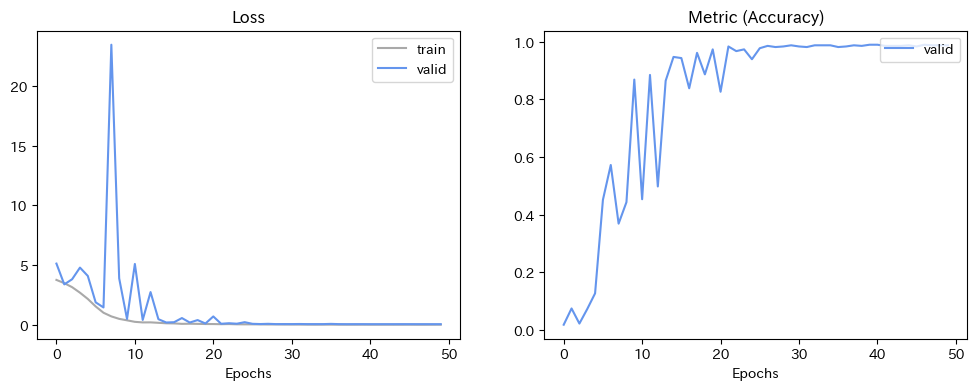

In [46]:
visualize_history(loss, val_acc, val_loss)

#7. Save model

In [ ]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [50]:
log_dir

'logs/fit/resnet18/20230712-082204'

In [53]:
#Save state dict
saved_model_path = "./" + log_dir
torch.save(model.state_dict(), saved_model_path)

RuntimeError: ignored

In [56]:
saved_model_path = "./logs/fit/resnet18/20230712-082204.pt"
torch.save(model, saved_model_path)

#8. Explore model

In [ ]:
model_path_for_exploring = "./models/1/model.pt"
model_x = torch.load(model_path_for_exploring)


In [ ]:
model_x = model_x.to(cfg.device)

In [ ]:
# get some random training images
dataiter = iter(valid_dataloader)
images, labels = next(dataiter)

In [ ]:
images.shape

torch.Size([32, 3, 224, 224])

In [ ]:
labels

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [ ]:
len(images)

32

In [ ]:
X = images.to(cfg.device)
y = labels.to(cfg.device)

with torch.no_grad():
    # Forward: Get model outputs
    y_pred = model_x(X)

    # Forward: Calculate loss
    loss = criterion(y_pred, y)

    # Covert y and y_pred to lists
    y =  y.detach().cpu().numpy().tolist()
    y_pred =  y_pred.detach().cpu().numpy().tolist()

    # Extend original list
    final_y_pred_argmax = np.argmax(y_pred, axis=1)
    final_y_argmax = np.argmax(y, axis = 1)
    metric_test = calculate_metric(final_y_argmax, final_y_pred_argmax)

In [ ]:
metric_test

1.0

In [ ]:
final_y_pred_argmax

array([45, 30, 10, 19, 18,  7,  1, 17,  6, 14,  0, 10, 40, 45, 24,  8, 14,
       30, 44, 15, 41,  5,  6, 19, 40, 11, 30,  8, 37, 31, 32,  3])

In [ ]:
final_y_argmax

array([45, 30, 10, 19, 18,  7,  1, 17,  6, 14,  0, 10, 40, 45, 24,  8, 14,
       30, 44, 15, 41,  5,  6, 19, 40, 11, 30,  8, 37, 31, 32,  3])

In [ ]:
test_df

,file_name,label
310,./data/hira_better_quality/ん/15.jpg,ん
161,./data/hira_better_quality/ま/11.jpg,ま
70,./data/hira_better_quality/さ/10.jpg,さ
686,./data/hira_better_quality/と/23.jpg,と
986,./data/hira_better_quality/て/9.jpg,て
...,...,...
1335,./data/hira_better_quality/す/18.jpg,す
920,./data/hira_better_quality/ら/18.jpg,ら
1092,./data/hira_better_quality/い/16.jpg,い
31,./data/hira_better_quality/に/13.jpg,に


In [ ]:
def inference_for_an_image(image_path = None, model_x = None):
  image = cv2.imread(image_path)

  # Convert the image to RGB color space.
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Apply augmentations
  transform = A.Compose([A.Resize(cfg.image_size, cfg.image_size),
                              ToTensorV2()])
  augmented = transform(image=image)
  image = augmented['image']

  image = image/255
  image = image.to(cfg.device)

  image_tensor_batch1 = image.unsqueeze(0)

  predict = model_x(image_tensor_batch1)
  y_pred1 =  predict.detach().cpu().numpy()
  character_label = labels[np.argmax(y_pred1)]

  return character_label

In [ ]:
sort_df["predicted_labels"] = sort_df["file_name"].apply(lambda x : inference_for_an_image(str(x), model_x))

In [ ]:
comparison = sort_df["label"] == sort_df["predicted_labels"]
sort_df["Correct"] = comparison

In [ ]:
len(sort_df)

1560

In [ ]:
sort_df["Correct"].sum()

1549

In [ ]:
sort_df2 = sort_df[sort_df["Correct"] == False]

In [ ]:
sort_df2

,file_name,label,predicted_labels,Correct
1508,./data/hira_better_quality/あ/28.jpg,あ,よ,False
716,./data/hira_better_quality/そ/16.jpg,そ,を,False
964,./data/hira_better_quality/つ/1.jpg,つ,ち,False
577,./data/hira_better_quality/ね/26.jpg,ね,れ,False
1155,./data/hira_better_quality/は/14.jpg,は,ほ,False
1159,./data/hira_better_quality/は/19.jpg,は,ほ,False
1192,./data/hira_better_quality/も/21.jpg,も,よ,False
112,./data/hira_better_quality/ゆ/24.jpg,ゆ,ぬ,False
123,./data/hira_better_quality/ゆ/25.jpg,ゆ,め,False
1382,./data/hira_better_quality/り/1.jpg,り,て,False


In [ ]:
1549/1560

0.992948717948718

In [ ]:
len(sort_df2)

11

Create a plot to view

In [ ]:
from PIL import Image


In [ ]:
num_rows = len(sort_df)
num_cols = 1

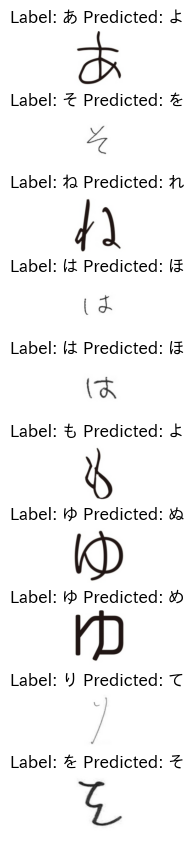

In [ ]:
fig, axs = plt.subplots(len(sort_df2)-1, 1, figsize=(2, 10))

# Iterate over the rows of the DataFrame
i = 0
for index, row in sort_df2.iterrows():
    # Get the image path, label, and predicted label
    if index == 964: continue
    image_path = row['file_name']
    label = row['label']
    predicted_label = row['predicted_labels']

    # Load and display the image
    image = Image.open(image_path)
    plt.imshow(image)
    # print(image)
    axs[i].imshow(image)
    axs[i].set_title(f'Label: {label} Predicted: {predicted_label}')
    axs[i].axis('off')

    axs[i].set_xticks([])
    axs[i].set_yticks([])
    i+= 1

# Adjust the spacing between subplots
# plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.5)

plt.savefig('./models/1/explore_model/wrong_results.jpg')
# Show the plot
plt.show()


In [ ]:
image_path = "./data/hira_better_quality/ん/15.jpg"
a = inference_for_an_image(image_path = image_path, model_x = model_x)
print(a)

./data/hira_better_quality/ん/15.jpg
torch.Size([1, 3, 224, 224])
ん


In [ ]:
test_df["predicted_labels"] = df["file_name"].apply(lambda x : inference_for_an_image(str(x), model_x))

In [ ]:
comparison = test_df["label"] == test_df["predicted_labels"]

In [ ]:
test_df["Correct"] = comparison

In [ ]:
len(test_df)

312

In [ ]:
test_df["Correct"].sum()

301

In [ ]:
301/312

0.9647435897435898

In [ ]:
test_df2 =  test_df[test_df["Correct"] == False]

In [ ]:
test_df2

NameError: ignored

##8.2. Save explored results

In [ ]:
explored_saved_results_path = "./models/1/explore_model/all_data_results.xlsx"

In [ ]:
sort_df.to_excel(explored_saved_results_path, index = False)

#9. References
+ https://towardsdatascience.com/pytorch-image-classification-tutorial-for-beginners-94ea13f56f2

#10. Draft code

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
image_path = "./data/hira_better_quality/ん/15.jpg"

In [ ]:
img = cv2.imread(image_path)

In [ ]:
img.shape


(180, 180, 3)

In [ ]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
a = train_transform(image = img,)

In [ ]:
a

{'image': tensor([[[0.8276, 0.8276, 0.8276,  ..., 0.8276, 0.8276, 0.8276],
          [0.8276, 0.8276, 0.8276,  ..., 0.8276, 0.8276, 0.8276],
          [0.8276, 0.8276, 0.8276,  ..., 0.8276, 0.8276, 0.8276],
          ...,
          [0.8276, 0.8276, 0.8276,  ..., 0.8276, 0.8276, 0.8276],
          [0.8276, 0.8276, 0.8276,  ..., 0.8276, 0.8276, 0.8276],
          [0.8276, 0.8276, 0.8276,  ..., 0.8276, 0.8276, 0.8276]],
 
         [[0.9405, 0.9405, 0.9405,  ..., 0.9405, 0.9405, 0.9405],
          [0.9405, 0.9405, 0.9405,  ..., 0.9405, 0.9405, 0.9405],
          [0.9405, 0.9405, 0.9405,  ..., 0.9405, 0.9405, 0.9405],
          ...,
          [0.9405, 0.9405, 0.9405,  ..., 0.9405, 0.9405, 0.9405],
          [0.9405, 0.9405, 0.9405,  ..., 0.9405, 0.9405, 0.9405],
          [0.9405, 0.9405, 0.9405,  ..., 0.9405, 0.9405, 0.9405]],
 
         [[1.0714, 1.0714, 1.0714,  ..., 1.0714, 1.0714, 1.0714],
          [1.0714, 1.0714, 1.0714,  ..., 1.0714, 1.0714, 1.0714],
          [1.0714, 1.0714, 1.07